In this notebook I am going to make a **Deep Learning** model which can be used to detect a person is wearing a mask or not. We will use VGG16 architecture to train our model to get good accuracy. What is VGG16? We are not going to address that in this notebook, to know more about VGG16 you ca follow this [link](https://neurohive.io/en/popular-networks/vgg16/).

## Pre-requisites

To understand this notebook you must fulfill some pre-requisites.

1. Basic of Python
2. Introduction to Machine Learning and Deep Learning
3. Basic information about [kaggle](https://kaggle.com)


# Getting the dataset from kaggle

First step for every Machine Learning or Deep Learning project is collection of **good** data. Nowdays vast amount of data is produced everyday, so extracting a good data from raw data is really big headache. So, [kaggle](https://kaggle.com) jumps in here to save our lots of time. It has collection of good amount of data. Our data also belongs to [kaggle](https://kaggle.com) on which we are going to train the model. You can read more about the dataset [here](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset).

Followinf is a code to import dataset from kaggle to the colab environment.

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

You need to generate the API key of your account from kaggle. To do that follow the next steps -->
1. Go to ```Account``` section in your kaggle profile.
2. Then go to ```API``` click on ```Generate API key```.
3. ```kaggle.json``` file will be downloaded.

Now execute the following line of code and upload it here.

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hrithikpawar","key":"7542ddd020b91e43980e58a2f5db7986"}'}

Execute the following commandline instructions to make required changes.

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Let's check we have kaggle completely installed and correctly cofigured or not.

In [6]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              216KB  2021-03-18 08:52:01            575  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            506  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            443  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            199  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In output if you get a list of various datasets then you are successfully installed the kaggle package.

Now, for every dataset in kaggle there a command to download the dataset. We need to copy that image and execute it here to download the ```.zip``` file of the dataset.

Below is a command to download the dataset on which we are going to train our dataset.

In [7]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:04<00:00, 73.8MB/s]
100% 330M/330M [00:04<00:00, 83.0MB/s]


After executing above code we will get the ```.zip``` file of our dataset. So we will use ```unzip``` command to unzip our dataset.

In [8]:
!unzip /content/face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

As you can see dataset is completely unziped now and we are ready to use that dataset. Let's us proceed to next step

# Pre-Processing the data

We cannot pass the data as it is to the model to be trained, we need to pre-process it to extract maximum amount of features from the image. So now we will perform **Data Augmentation** on our dataset, to normalize the image, to add some extra features and make images ready to be passed to train the model.

Here we are going to use the ```ImageDataGenerator``` class to perform the **Data Augmentation** on dataset.

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Let's fix the ```INPUT_SHAPE``` because the images we have in our dataset are not in same size. So it is important to have the same size of images. 

In [10]:
# Important variables 
INPUT_SIZE = [128,128]
BATCH = 32

In [11]:
training_datagen = ImageDataGenerator(rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range = 0.2,
                                      )

training_data = training_datagen.flow_from_directory('/content/Face Mask Dataset/Train',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary'
                                                     )

Found 10000 images belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = training_datagen.flow_from_directory('/content/Face Mask Dataset/Test',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     class_mode = 'binary'
                                                     )

Found 992 images belonging to 2 classes.


Now, our data is ready to be passed to train the model. 

# Importing VGG16 Model's Architecture

In this step we are going to import the ```VGG16``` architecture from ```keras```. ```VGG16``` is a winner of ```imagenet``` compitition in 2014. So, we are going to use the same weights used to train actual VGG16 Image Classification model from that compitition. This will save our lots time and lots of resources too. 

In [13]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

Following is code which we will be using to import the ```VGG16``` architecture. We will pass the three parameters, that are input size of an image, ```weights="imagenet"``` and ```include_top=Flase```.

```include_top``` is false because we don't need to import whole architecture. We need only the **Convolutional architecture** of VGG16. After that we will add our layer and which will be trained according to our dataset.

In [14]:
vgg16 = VGG16(input_shape=INPUT_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


We imported the VGG16 architecture but we need to freeze the weight to prevent it from changing in **Backpropogation** process.

In [15]:
for layer in vgg16.layers:
    layer.trainable = False

In [16]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Above you can see the VGG16 architecture, there are total ```14,714,688``` parameters but they are non-trainable because we freezed them. They will not change in backpropogation. 

Now we need to add some more trainable layer which will be trained according to our dataset. 

In [17]:
flatten = Flatten()(vgg16.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)
dense_output = Dense(units=1, activation='sigmoid')(dense_4)




In [18]:
model = Model(inputs=vgg16.input, outputs=dense_output)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Above is our model architecture that we are going to use. 



# Training The Model

Now,our dataset and Model both are ready to be utilized. Let's train our model.

In [20]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [21]:
r = model.fit_generator(
  training_data,
  validation_data=test_data,
  epochs=60,
  steps_per_epoch=len(training_data),
  validation_steps=len(test_data)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
313/313 [==============================] - 77s 145ms/step - loss: 0.1396 - accuracy: 0.9344 - val_loss: 0.0444 - val_accuracy: 0.9849
Epoch 2/60
313/313 [==============================] - 44s 142ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 0.0820 - val_accuracy: 0.9718
Epoch 3/60
313/313 [==============================] - 45s 142ms/step - loss: 0.0361 - accuracy: 0.9851 - val_loss: 0.0419 - val_accuracy: 0.9849
Epoch 4/60
313/313 [==============================] - 45s 144ms/step - loss: 0.0154 - accuracy: 0.9942 - val_loss: 0.0337 - val_accuracy: 0.9909
Epoch 5/60
313/313 [==============================] - 45s 142ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.0316 - val_accuracy: 0.9940
Epoch 6/60
313/313 [==============================] - 45s 143ms/step - loss: 0.0181 - accuracy: 0.9929 - val_loss: 0.0181 - val_accuracy: 0.9950
Epoch 7/60
313/313 [==============================] - 45s 142ms/step - loss: 0.0063 - accuracy: 0.9975 - val_loss: 0.0221 - val_ac

# Visualizing Training of Model

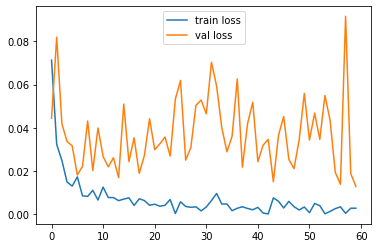

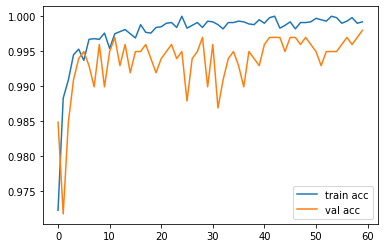

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Validating the Model

In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/Face Mask Dataset/Validation/WithoutMask/1348.png', target_size = INPUT_SIZE)
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result[0][0]

1.0

In [24]:
if result[0][0] < 0.5:
    print('Image classified as WithMAsk')
else:
    print('Image classified as Without Mask')

Image classified as Without Mask


In [25]:
model.save('face_mask_vgg16.h5')

In [26]:
files.download('face_mask_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>